# Importing basic nessary header files

In [3]:
import tensorflow as tf  # Importing tensorflow library
import os  # Used to open directroy in differen system
import cv2  # For Image displaying and resizing
import imghdr  # To check Image type
import matplotlib.pyplot as plt  # For ploting graphs
import numpy as np  # numpy Array

# Setting up GPU Memory Consumption so that it doesn't go out of GPU

In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Mounting Google drive

In [4]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
data_dir = '/content/drive/MyDrive/CellDataset' # All reqired Image directory
storage_dir = '/content/drive/MyDrive/CNN Cell Dataset'  # Stores the files of the model
image_exts = ['jpeg','jpg', 'bmp', 'png']  # Only this type of images are excepted

# Removing unwanted image type other than in list

In [ ]:
# To check and remove the unwanted image type

for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# Data Augmentation

In [24]:
#Data Augmentation libraries
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array
from tensorflow.keras.utils import load_img

In [25]:
# Data augmentation
datagen = image.ImageDataGenerator(
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    # vertical_flip = True,
    rotation_range = 10,
    brightness_range = (1, 2)
)

**Augmention if the data is low**

In [ ]:
# Data Augmentation and saving in our specific directroy

for image_class in os.listdir(data_dir):
  for image in os.listdir(os.path.join(data_dir, image_class)):
    image_path = os.path.join(data_dir, image_class, image)
    img = load_img(image_path)
    img_arr = img_to_array(img)
    img_arr = img_arr.reshape((1, ) + img_arr.shape)
    i = 0
    for aug in datagen.flow(img_arr, batch_size = 2,
                           save_to_dir = os.path.join(data_dir, image_class),
                           save_prefix = 'Aug_Image', save_format = 'jpg'):
     i += 1
     if i > 29:
        break

# Load the data

In [26]:
data = tf.keras.utils.image_dataset_from_directory(data_dir, batch_size = 16, label_mode= 'int')
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

Found 2697 files belonging to 6 classes.


In [27]:
class_names = data.class_names  # Stores class names
print(class_names)
num_image_class = len(data.class_names)  # Stores the number of image classes
print("Number of classes %i" %num_image_class)

['1', '2', '3', '4', '5', '6']
Number of classes 6


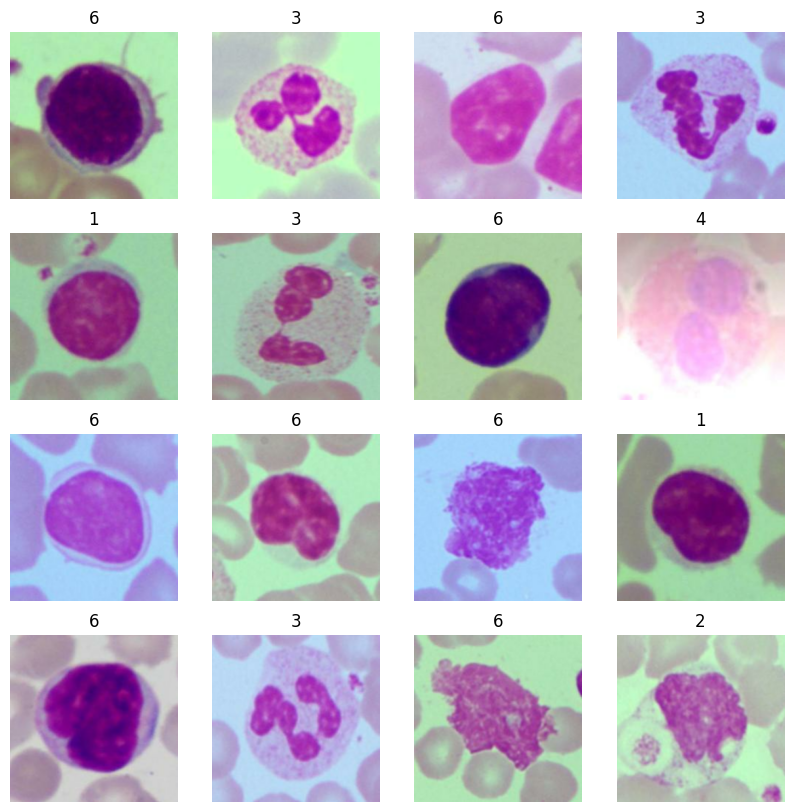

In [10]:
plt.figure(figsize=(10, 10))
for images, labels in data.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [28]:
# data = data.map(lambda x,y: (x/255, y))
data.as_numpy_iterator().next()

(array([[[[150.      , 220.      , 168.      ],
          [150.      , 220.      , 168.      ],
          [150.      , 220.      , 168.      ],
          ...,
          [149.2832  , 177.7168  , 160.5664  ],
          [150.      , 177.      , 162.      ],
          [150.      , 177.      , 162.      ]],
 
         [[151.66016 , 221.66016 , 169.66016 ],
          [150.97113 , 220.97113 , 168.97113 ],
          [150.83008 , 220.83008 , 168.83008 ],
          ...,
          [147.62305 , 176.05664 , 158.90625 ],
          [148.33984 , 175.33984 , 160.33984 ],
          [148.33984 , 175.33984 , 160.33984 ]],
 
         [[153.4336  , 223.4336  , 171.4336  ],
          [152.60352 , 222.60352 , 170.60352 ],
          [152.4336  , 222.4336  , 170.4336  ],
          ...,
          [146.05261 , 172.84961 , 156.41602 ],
          [147.2832  , 172.13281 , 157.84961 ],
          [147.2832  , 172.13281 , 157.84961 ]],
 
         ...,
 
         [[146.      , 159.      , 149.      ],
          [145.169

In [29]:
len(data)

169

# Setting-up train, test and validation

In [30]:
train_size = int(len(data)*.8)
test_size = int((int(len(data)) - train_size) * 0.5)
val_size= int(int(len(data)) - train_size - test_size)
print(train_size)
print(test_size)
print(val_size)

135
17
17


In [31]:
train_dataset = data.take(train_size)
validation_dataset = data.skip(train_size).take(val_size)
test_dataset = data.skip(train_size+val_size).take(test_size)

In [32]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

In [33]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [34]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

# Constructing base model with Mobile Net V2

In [35]:
# Create the base model from the pre-trained model MobileNet V2
# IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=(256, 256, 3),
                                               include_top=False,
                                               weights='imagenet')

<ipython-input-35-0f6a36fc7e20>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(input_shape=(256, 256, 3),


In [36]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(16, 8, 8, 1280)


In [37]:
base_model.trainable = False

In [27]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 128, 128, 32)   │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 128, 128, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 128, 128, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 128, 128, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 128, 128, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 128, 128, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 128, 128, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 128, 128, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 128, 128, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 128, 128, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 128, 128, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 129, 129, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 64, 64, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

# Model requierment

In [38]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(16, 1280)


In [39]:
if num_image_class == 1:
  Loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
  Matrix = tf.keras.metrics.BinaryIoU(target_class_ids = (0, 1), threshold=0.5, name='accuracy', dtype=None)
  Activation = "sigmoid"
  print("class 1")
elif num_image_class == 2:
  Loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)
  Matrix = [tf.keras.metrics.BinaryAccuracy(threshold=0, name='accuracy')]
  Activation = "sigmoid"
  print("class 2")
else:
   Loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
   Matrix = [tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')]
   Activation = "softmax"
   print("class 3")

class 3


In [40]:
prediction_layer = tf.keras.layers.Dense(num_image_class, activation = Activation)

prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(16, 6)


In [41]:
inputs = tf.keras.Input(shape=(256, 256, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [40]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide_1 (TrueDivide)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract_1 (Subtract)                │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 8, 8, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │           7,686 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,265,670 (8.64 MB)

 Trainable params: 7,686 (30.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [42]:
len(model.trainable_variables)

2

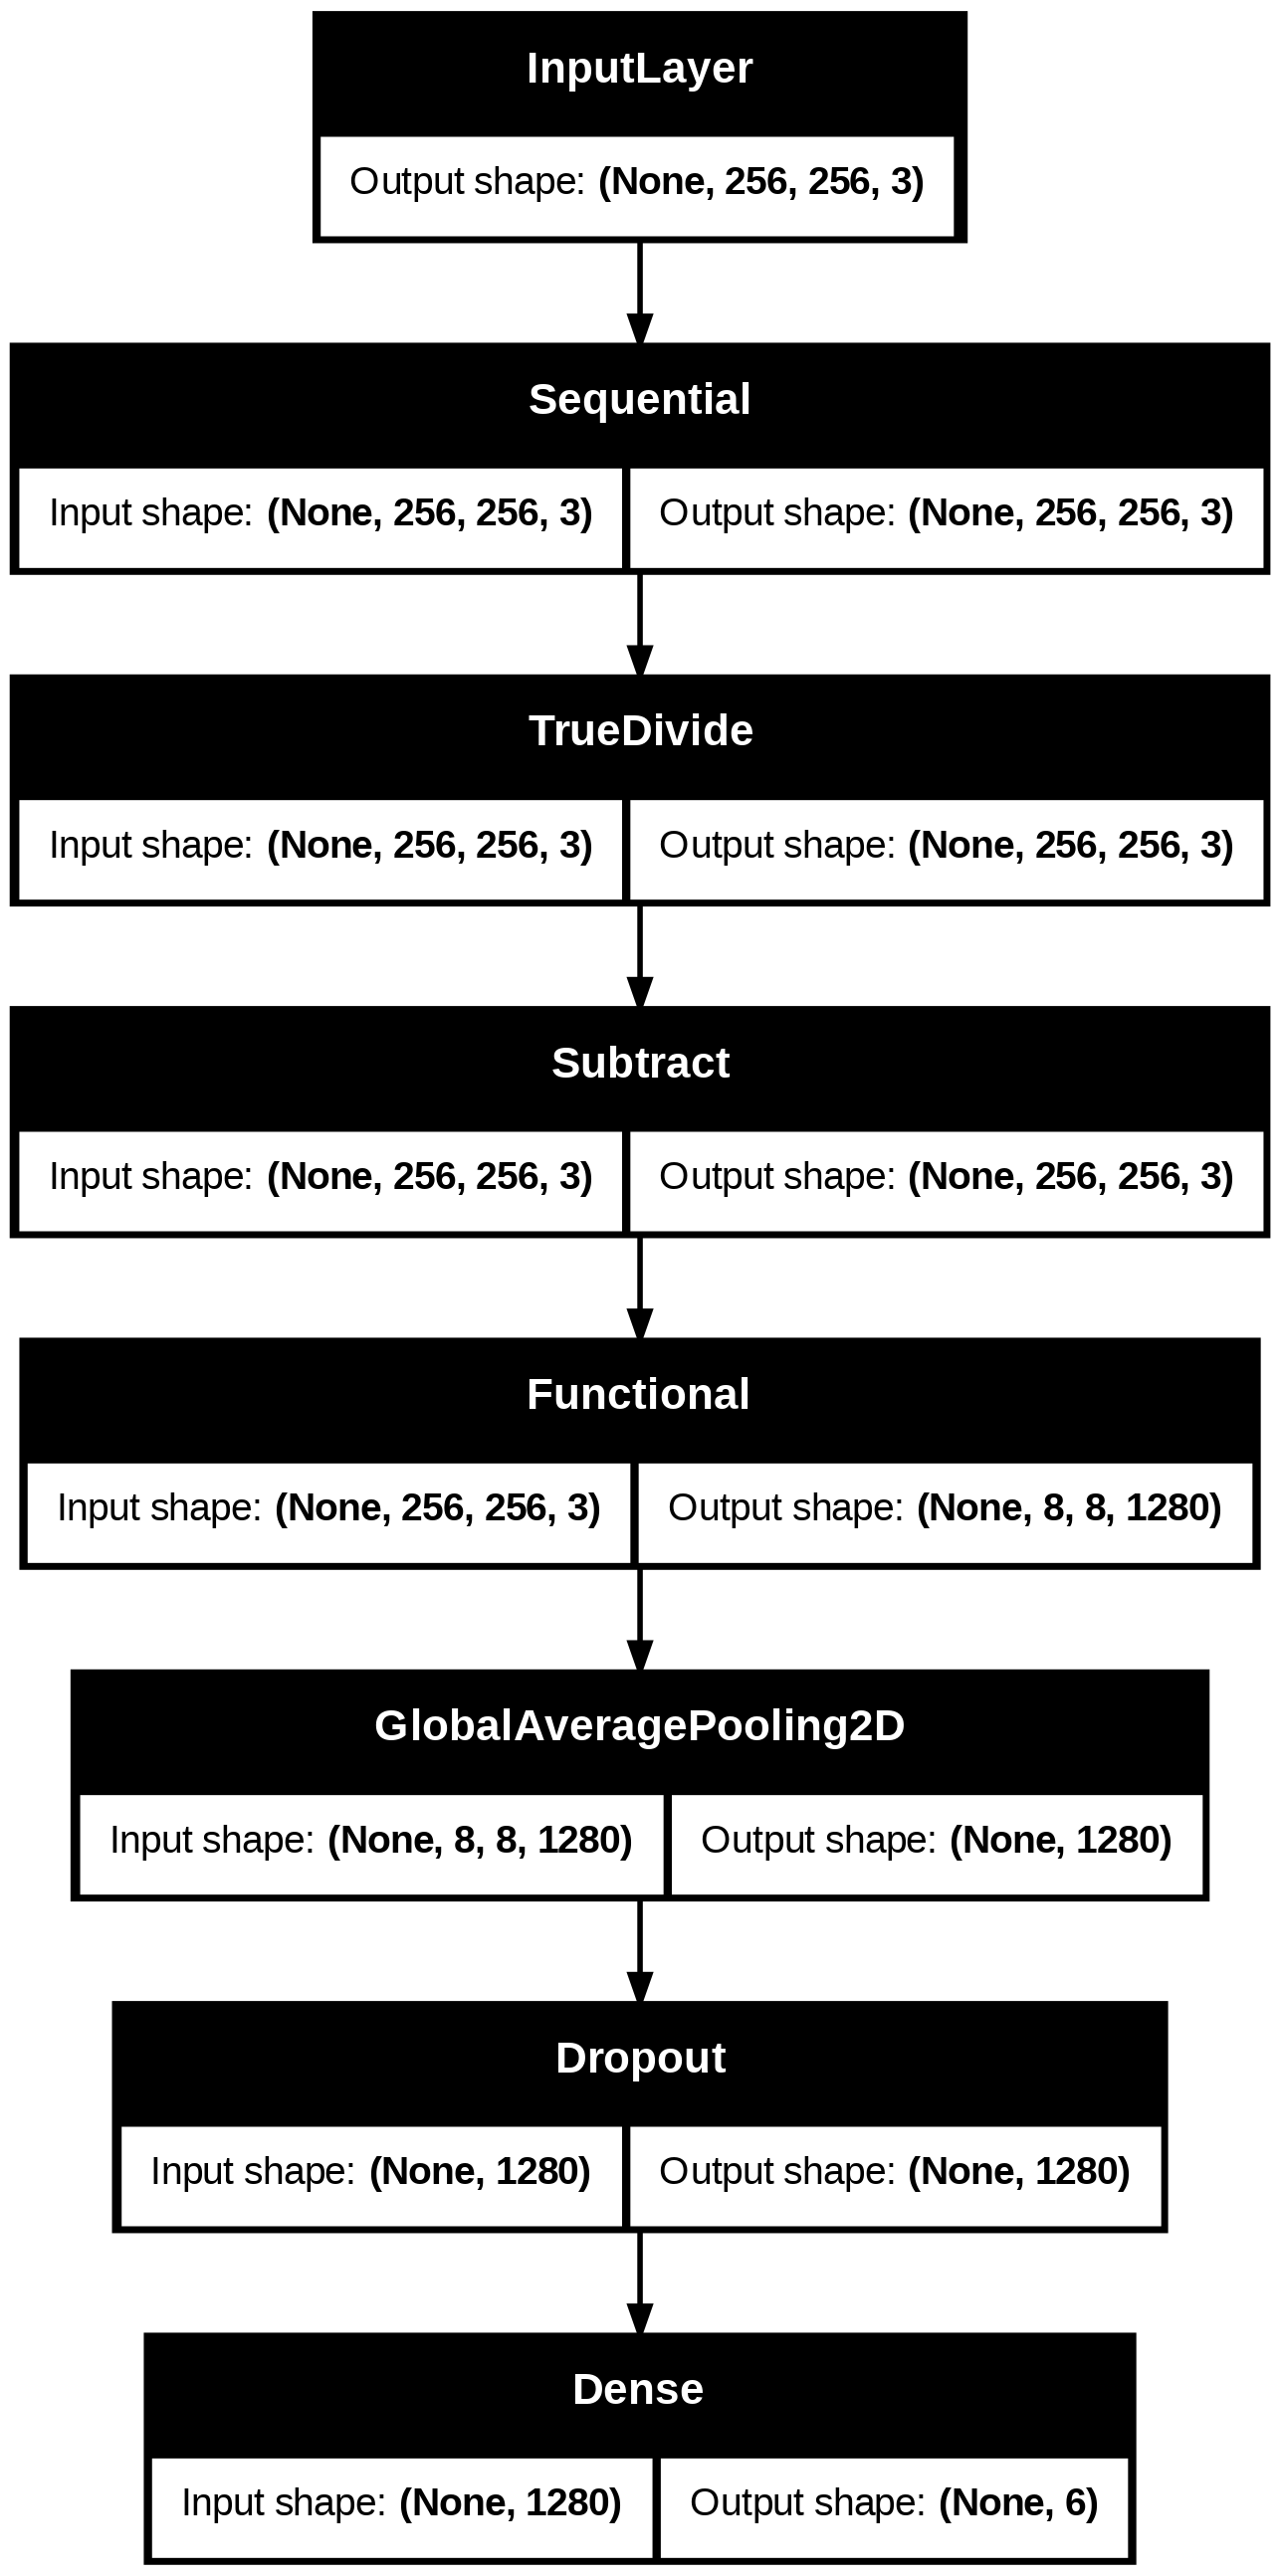

In [42]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [43]:
base_learning_rate = 0.0001
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = base_learning_rate),
              loss = Loss,
              metrics = Matrix
              )

# Fit the model

In [ ]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.15
initial accuracy: 1.00


In [45]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset,
                    callbacks = tf.keras.callbacks.TensorBoard(log_dir = 'log'))

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


135/135 ━━━━━━━━━━━━━━━━━━━━ 254s 2s/step - accuracy: 0.3755 - loss: 1.6712 - val_accuracy: 0.4926 - val_loss: 1.3229
Epoch 2/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 32s 235ms/step - accuracy: 0.5055 - loss: 1.2821 - val_accuracy: 0.5699 - val_loss: 1.0784
Epoch 3/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 19s 143ms/step - accuracy: 0.6041 - loss: 1.0540 - val_accuracy: 0.6801 - val_loss: 0.9221
Epoch 4/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 16s 117ms/step - accuracy: 0.6495 - loss: 0.9091 - val_accuracy: 0.6949 - val_loss: 0.8300
Epoch 5/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 18s 136ms/step - accuracy: 0.6995 - loss: 0.8104 - val_accuracy: 0.7463 - val_loss: 0.7307
Epoch 6/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 20s 145ms/step - accuracy: 0.7169 - loss: 0.7546 - val_accuracy: 0.7647 - val_loss: 0.6898
Epoch 7/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 17s 125ms/step - accuracy: 0.7584 - loss: 0.6856 - val_accuracy: 0.8088 - val_loss: 0.5877
Epoch 8/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 16s 116ms/step - accuracy: 0.7626 - loss: 0.6436 - val_a

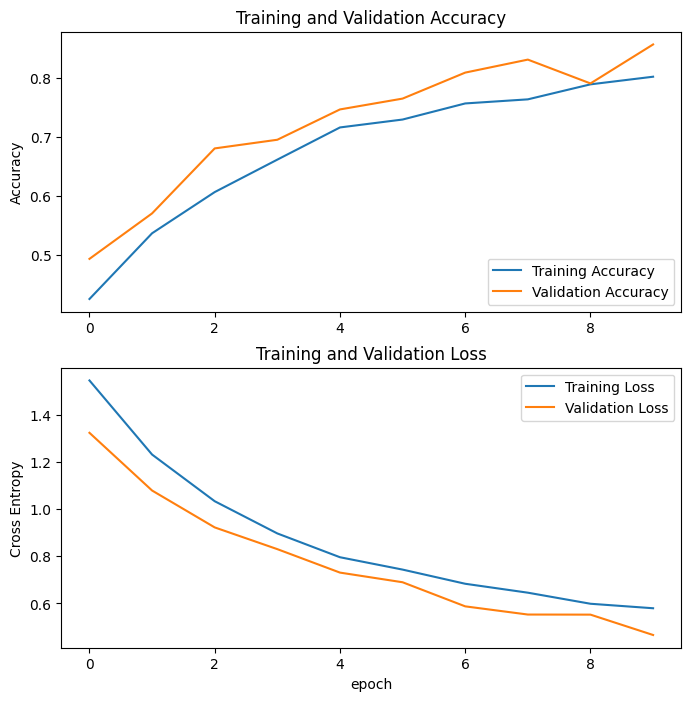

In [46]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
# model.save(os.path.join(storage_dir, 'models','mobileNetv2_1.h5'))

# Fine Tuning

In [47]:
base_model.trainable = True

In [48]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [49]:
model.compile(loss = Loss,
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=Matrix)

In [50]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide (TrueDivide)             │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract (Subtract)                  │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 8, 8, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │           7,686 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,265,670 (8.64 MB)

 Trainable params: 1,869,126 (7.13 MB)

 Non-trainable params: 396,544 (1.51 MB)

In [ ]:
len(model.trainable_variables)

56

In [51]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/15
135/135 ━━━━━━━━━━━━━━━━━━━━ 29s 131ms/step - accuracy: 0.6966 - loss: 1.1301 - val_accuracy: 0.7684 - val_loss: 0.6271
Epoch 11/15
135/135 ━━━━━━━━━━━━━━━━━━━━ 17s 125ms/step - accuracy: 0.7935 - loss: 0.6021 - val_accuracy: 0.7537 - val_loss: 0.6735
Epoch 12/15
135/135 ━━━━━━━━━━━━━━━━━━━━ 17s 125ms/step - accuracy: 0.8403 - loss: 0.4788 - val_accuracy: 0.7757 - val_loss: 0.6055
Epoch 13/15
135/135 ━━━━━━━━━━━━━━━━━━━━ 20s 124ms/step - accuracy: 0.8374 - loss: 0.4102 - val_accuracy: 0.7904 - val_loss: 0.5108
Epoch 14/15
135/135 ━━━━━━━━━━━━━━━━━━━━ 18s 133ms/step - accuracy: 0.8897 - loss: 0.3501 - val_accuracy: 0.8272 - val_loss: 0.4679
Epoch 15/15
135/135 ━━━━━━━━━━━━━━━━━━━━ 21s 155ms/step - accuracy: 0.8826 - loss: 0.3288 - val_accuracy: 0.8529 - val_loss: 0.3527


In [52]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

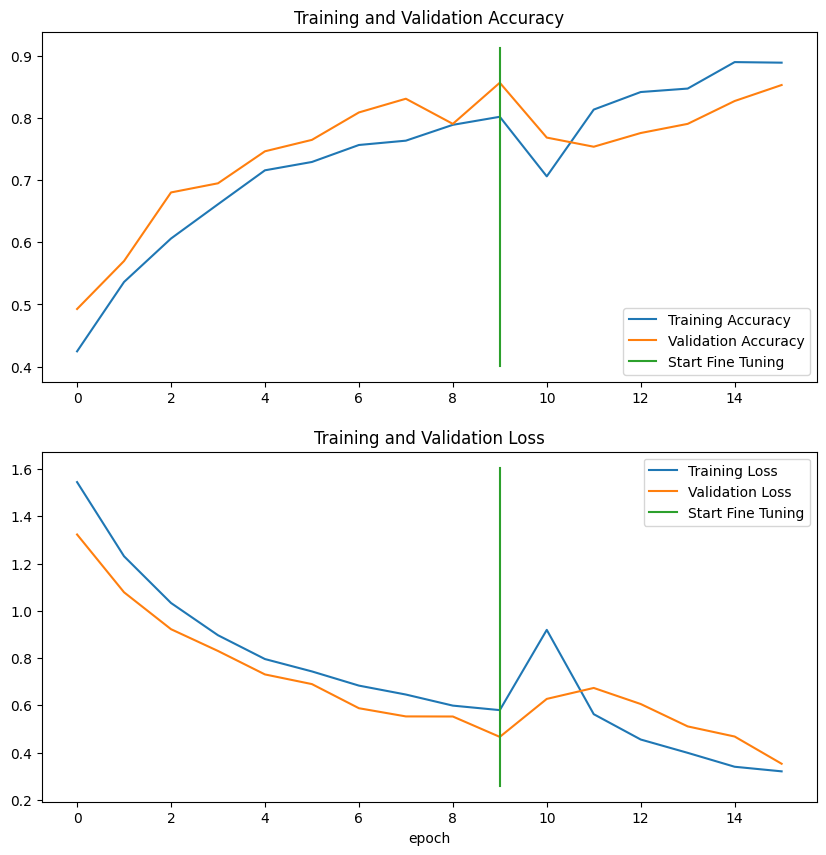

In [53]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
# plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
# plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [54]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)
print('Test Loss :', loss)

17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 720ms/step - accuracy: 0.8422 - loss: 0.3897
Test accuracy : 0.8226414918899536
Test Loss : 0.4181428551673889


# Save model at particular path

In [ ]:
# To save model in TFLite form
import tensorflow as tf

# model = tf.keras.models.load_model('model.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("/content/drive/MyDrive/CNN/models_3/mobileNetv2_2img.tflite", "wb").write(tflite_model)

8870432

In [ ]:
# To save model in Keras form
model.save(os.path.join(storage_dir, 'models','mobileNetv2_1.h5'))

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Load the model
# from tensorflow.keras.models import load_model
# new_model = load_model(os.path.join(storage_dir, 'models','mobileNetv2_1.h5'))


# Predictions and testing

In [ ]:
# For Binary Classification
def class_detection(arr):
    if arr[0][0] > 0.90 and arr[0][1] < 0.2:
      return [1, 0]
    elif  arr[0][0] < 0.20 and arr[0][1] > 0.9:
      return [0, 1]
    else:
      return [0, 0]

Probability:
 [[0.50004643 0.50201565 0.5003902  0.5004319  0.5000016  0.72878295]
 [0.65793025 0.5000323  0.50003135 0.5005979  0.50046533 0.5845325 ]
 [0.50003886 0.50199515 0.6050952  0.6149319  0.50156236 0.52268   ]
 [0.5000073  0.5000449  0.66624147 0.57592595 0.5001778  0.5004437 ]
 [0.500167   0.5002372  0.715658   0.5177951  0.500016   0.5010211 ]
 [0.5000014  0.5013706  0.7105334  0.5237302  0.50019044 0.50019556]
 [0.55883807 0.50001436 0.50000376 0.5000346  0.50005746 0.68202895]
 [0.50000936 0.50002724 0.7258046  0.50293905 0.5000032  0.503661  ]
 [0.50000036 0.7280641  0.5004632  0.50320876 0.5000388  0.5000831 ]
 [0.7303816  0.5000004  0.5000008  0.5000047  0.50000423 0.50085   ]
 [0.72488356 0.50000143 0.5000021  0.50000256 0.50000143 0.5077877 ]
 [0.5000353  0.50003237 0.5000097  0.5000989  0.7298208  0.5013954 ]
 [0.50123835 0.5015481  0.50029284 0.5155738  0.52805257 0.6927567 ]
 [0.5400664  0.5000225  0.5000121  0.5000637  0.50002015 0.6982369 ]
 [0.50000274 0.50002

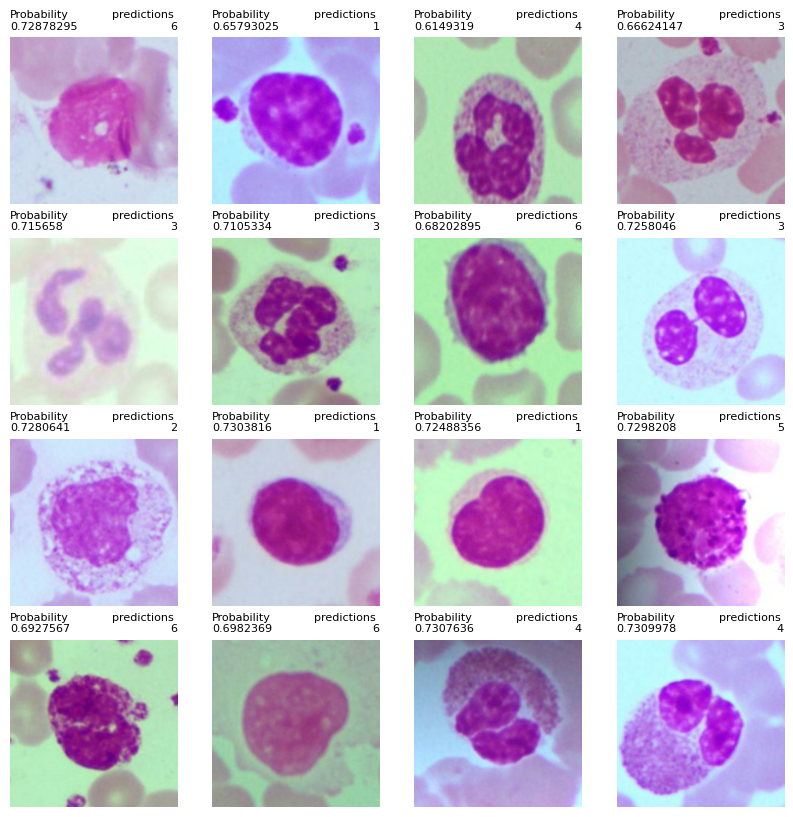

In [55]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

# Apply a sigmoid since our model returns logits
tf_predictions = tf.nn.sigmoid(predictions)
# predictions = tf.where(predictions < 0.5, 0, 1)

print('Probability:\n', tf_predictions.numpy())
print('Labels:\n', label_batch)
print(predictions)
print(label_batch)


plt.figure(figsize=(10, 10))
for i in range(16):
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title("predictions \n%s"%class_names[np.argmax(predictions[i])], fontsize = 8, loc = 'right')
  plt.title("Probability\n%s"%np.max(tf_predictions[i]), fontsize = 8, loc = 'left')
  plt.axis("off")

# Testing the model with other wrong data

In [ ]:
# To check and remove the unwanted image type

wrong_data_dir = '/content/drive/MyDrive/CNN'
for image_class in os.listdir(wrong_data_dir):
    for image in os.listdir(os.path.join(wrong_data_dir, image_class)):
        image_path = os.path.join(wrong_data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

In [ ]:
#Data Augmentation libraries
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array
from tensorflow.keras.utils import load_img

In [ ]:
# Data augmentation
wrong_datagen = image.ImageDataGenerator(
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    # vertical_flip = True,
    rotation_range = 10,
    brightness_range = (1, 2)
)

In [ ]:
wrong_data = tf.keras.utils.image_dataset_from_directory(wrong_data_dir, batch_size = 16, label_mode= 'int')
wrong_data_iterator = wrong_data.as_numpy_iterator()
wrong_batch = wrong_data_iterator.next()

Found 182 files belonging to 1 classes.


In [ ]:
img = cv2.imread('/content/drive/MyDrive/MSISLogo.png')
resize = tf.image.resize(img, (256,256))
yhat = model.predict(np.expand_dims(resize/255, 0))
print("----1-----")
print(yhat)
# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(yhat)
print(predictions)
predictions = tf.where(predictions < 0.2, 0, 1)

print('Predictions:\n', predictions.numpy())
# print('Labels:\n', label_batch)

1/1 [==============================] - 0s 117ms/step
----1-----
[[ 2.912695  -1.0540628]]
tf.Tensor([[0.9484704  0.25844568]], shape=(1, 2), dtype=float32)
Predictions:
 [[1 1]]


In [ ]:
wrong_data_dir = '/content/drive/MyDrive/MITE/P & S/PAVAN&SUPRABHA/DDDD'
for wrong_img in os.listdir(wrong_data_dir):
    path = os.path.join(wrong_data_dir, wrong_img)
    img = cv2.imread(path)
    resize = tf.image.resize(img, (256,256))
    yhat = model.predict(np.expand_dims(resize/255, 0))
    # Apply a sigmoid since our model returns logits
    predictions = tf.nn.sigmoid(yhat)
    print(predictions.numpy())

1/1 [==============================] - 0s 76ms/step
[[0.9435941  0.27456522]]
1/1 [==============================] - 0s 66ms/step
[[0.9380522  0.26413178]]
1/1 [==============================] - 0s 105ms/step
[[0.93873113 0.26377445]]
1/1 [==============================] - 0s 65ms/step
[[0.9400537  0.26785687]]
1/1 [==============================] - 0s 101ms/step
[[0.94693077 0.24680693]]
1/1 [==============================] - 0s 107ms/step
[[0.9487165  0.27159667]]
1/1 [==============================] - 0s 61ms/step
[[0.9464892  0.27665737]]
1/1 [==============================] - 0s 69ms/step
[[0.94603086 0.28009   ]]
1/1 [==============================] - 0s 68ms/step
[[0.9451279 0.2699426]]
1/1 [==============================] - 0s 65ms/step
[[0.94629765 0.2725677 ]]
1/1 [==============================] - 0s 69ms/step
[[0.9486377 0.2564461]]
1/1 [==============================] - 0s 65ms/step
[[0.9446764  0.27450377]]
1/1 [==============================] - 0s 62ms/step
[[0.946555   

In [ ]:
# To check and remove the unwanted image type

wrong_data_dir = '/content/drive/MyDrive/STR storage'
for image_class in os.listdir(wrong_data_dir):
    for image in os.listdir(os.path.join(wrong_data_dir, image_class)):
        os.listdir(wrong_data_dir):
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# Un-named

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

# Apply a sigmoid since our model returns logits
tf_predictions = tf.nn.sigmoid(predictions)
# predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', tf_predictions.numpy())
print('Labels:\n', label_batch)

loss, accuracy = model.evaluate(test)
print('Test accuracy :', accuracy)
print('Loss :', loss)

In [ ]:
# Function for batch prediction when number of class = 1
def batchPrediction_uniary():
  image_batch, label_batch = test_dataset.as_numpy_iterator().next()
  predictions = model.predict_on_batch(image_batch).flatten()

  # Apply a sigmoid since our model returns logits
  predictions = tf.nn.sigmoid(predictions)
  predictions = tf.where(predictions < 0.5, 0, 1)

  print('Predictions:\n', predictions.numpy())
  print('Labels:\n', label_batch)

  plt.figure(figsize=(10, 10))
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predictions[i]])
    plt.axis("off")


In [ ]:
# Function for batch prediction when number of class = 2
def batchPrediction_binary():
  # Retrieve a batch of images from the test set
  image_batch, label_batch = test.as_numpy_iterator().next()
  predictions = model.predict_on_batch(image_batch)

  # Apply a sigmoid since our model returns logits
  tf_predictions = tf.nn.sigmoid(predictions)
  # predictions = tf.where(predictions < 0.5, 0, 1)

  print('Predictions:\n', tf_predictions.numpy())
  print('Labels:\n', label_batch)

  plt.figure(figsize=(10, 10))
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predictions[i]])
    plt.axis("off")
